# <center> Codebase for creating Monkeypox Knowledge Graph

### System details

In [1]:
import getpass
import sys
import time

In [2]:
getpass.getuser()

'Reagon.Karki'

In [3]:
sys.version

'3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]'

In [2]:
time.asctime()

'Tue Feb  7 09:32:50 2023'

### Importing packages

In [5]:
#pip install -r requirements.txt

In [2]:
import pybel
from pybel.io.jupyter import to_jupyter
from utils import *
import matplotlib.pyplot as plt

C:\Users\reagon.karki\Anaconda3\envs\bycovid_new\lib\site-packages\pybel\struct\operations.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# The following codes have to be executed line by line to generate the final KG. Alternatively, you can use the cached file of the final KG. Press Ctrl+F and type 'Final KG'

# Drugs against monkeypox 

This data was collected from ChEMBL database

In [7]:
mpox_chembl = pd.read_csv(
    'data/chembl/chembl_mpox_actives_new.csv',
    sep=';',
    usecols=[
        'Molecule ChEMBL ID',
        'pChEMBL Value'
    ])
mpox_chembl= mpox_chembl[mpox_chembl['pChEMBL Value'] >= 6]
mpox_chembl = set(mpox_chembl['Molecule ChEMBL ID'])

In [8]:
mpox_chembl

{'CHEMBL1257073',
 'CHEMBL220150',
 'CHEMBL220610',
 'CHEMBL221054',
 'CHEMBL375768'}

# Extracting data from PubChem

Following line of codes extract information from [PubChem](https://pubchem.ncbi.nlm.nih.gov/taxonomy/10244). The file can be donwloaded from the "Chemicals and Bioactivities" section. [Tabel 3.1](https://pubchem.ncbi.nlm.nih.gov/taxonomy/10244#section=Tested-Compounds&fullscreen=true)

In [9]:
mpox_pchem = pd.read_csv(
    'data/pubchem/TaxID_10244_bioactivity.csv'
)
mpox_pchem = mpox_pchem['cid']
mpox_pchem = set(mpox_pchem)

In [10]:
pchem2chembl_list = cid2chembl(mpox_pchem)

Converting PubChem ids to ChEMBL ids: 100%|██████████| 24/24 [00:29<00:00,  1.23s/it]


#### Checking overlap between the ChEMBL and Pubchem information

In [13]:
mpox_chembl.update(set(pchem2chembl_list))
len(mpox_chembl)

24

In [14]:
mpox_chembl

{'CHEMBL112159',
 'CHEMBL113930',
 'CHEMBL114867',
 'CHEMBL1257073',
 'CHEMBL152',
 'CHEMBL1643',
 'CHEMBL219691',
 'CHEMBL220098',
 'CHEMBL220150',
 'CHEMBL220610',
 'CHEMBL221054',
 'CHEMBL321500',
 'CHEMBL326139',
 'CHEMBL3290663',
 'CHEMBL3357215',
 'CHEMBL3357216',
 'CHEMBL360506',
 'CHEMBL3753489',
 'CHEMBL3753637',
 'CHEMBL375768',
 'CHEMBL392630',
 'CHEMBL4449833',
 'CHEMBL4565849',
 'CHEMBL494759'}

### Get proteins, mech of action, disease, and activity data from ChEMBL

In [15]:
chembl2mech = RetMech(list(mpox_chembl))

Retrieving mechanisms from ChEMBL: 100%|██████████| 24/24 [00:00<00:00, 177.66it/s]


In [16]:
chembl2mech

{'CHEMBL1257073': [{'action_type': 'INHIBITOR',
   'mechanism_of_action': 'Envelope phospholipase F13 (p37) inhibitor',
   'target_chembl_id': 'CHEMBL4296170'}],
 'CHEMBL152': [{'action_type': 'INHIBITOR',
   'mechanism_of_action': 'Human herpesvirus 1 DNA polymerase inhibitor',
   'target_chembl_id': 'CHEMBL1872'}],
 'CHEMBL1643': [{'action_type': 'INHIBITOR',
   'mechanism_of_action': "Inosine-5'-monophosphate dehydrogenase 1 inhibitor",
   'target_chembl_id': 'CHEMBL1822'},
  {'action_type': 'INHIBITOR',
   'mechanism_of_action': 'Hepatitis C virus NS5B RNA-dependent RNA polymerase inhibitor',
   'target_chembl_id': 'CHEMBL5375'},
  {'action_type': 'INHIBITOR',
   'mechanism_of_action': 'RNA inhibitor',
   'target_chembl_id': 'CHEMBL2363073'}]}

In [17]:
chembl2dis = RetDrugInd(mpox_chembl)


Retrieving diseases from ChEMBL: 100%|██████████| 24/24 [00:00<00:00, 174.49it/s]


In [18]:
chembl2dis

{'CHEMBL1257073': [{'mesh_heading': 'Virus Diseases'},
  {'mesh_heading': 'Smallpox'}],
 'CHEMBL152': [{'mesh_heading': 'Virus Diseases'},
  {'mesh_heading': 'Infections'},
  {'mesh_heading': 'Kidney Diseases'},
  {'mesh_heading': 'Sarcoma'},
  {'mesh_heading': 'Uterine Cervical Dysplasia'},
  {'mesh_heading': 'Cytomegalovirus Infections'},
  {'mesh_heading': 'Cytomegalovirus Retinitis'},
  {'mesh_heading': 'Anus Neoplasms'},
  {'mesh_heading': 'Papilloma'},
  {'mesh_heading': 'Uterine Cervical Neoplasms'},
  {'mesh_heading': 'Herpes Simplex'},
  {'mesh_heading': 'Primary Immunodeficiency Diseases'}],
 'CHEMBL1643': [{'mesh_heading': 'Leukemia, Myeloid, Acute'},
  {'mesh_heading': 'Hepatitis C, Chronic'},
  {'mesh_heading': 'Hepatitis C'},
  {'mesh_heading': 'Hepatitis B, Chronic'},
  {'mesh_heading': 'Infections'},
  {'mesh_heading': 'Neoplasms'},
  {'mesh_heading': 'HIV Infections'},
  {'mesh_heading': 'Liver Cirrhosis'},
  {'mesh_heading': 'Hepatitis B, Chronic'},
  {'mesh_heading':

In [19]:
chembl2act = RetAct(mpox_chembl)

Retrieving bioassays from ChEMBL: 100%|██████████| 24/24 [00:00<00:00, 236.02it/s]


In [20]:
chembl2act

{'CHEMBL3753637': [{'assay_chembl_id': 'CHEMBL3757541',
   'assay_type': 'B',
   'bao_label': 'single protein format',
   'pchembl_value': '8.49',
   'target_chembl_id': 'CHEMBL3751646',
   'target_organism': 'Homo sapiens',
   'type': 'IC50',
   'value': '3.2'}],
 'CHEMBL1643': [{'assay_chembl_id': 'CHEMBL1614108',
   'assay_type': 'A',
   'bao_label': 'single protein format',
   'pchembl_value': '6.10',
   'target_chembl_id': 'CHEMBL340',
   'target_organism': 'Homo sapiens',
   'type': 'Potency',
   'value': '0.7943'},
  {'assay_chembl_id': 'CHEMBL1613886',
   'assay_type': 'A',
   'bao_label': 'single protein format',
   'pchembl_value': '6.10',
   'target_chembl_id': 'CHEMBL340',
   'target_organism': 'Homo sapiens',
   'type': 'Potency',
   'value': '0.7943'}],
 'CHEMBL3290663': [{'assay_chembl_id': 'CHEMBL3294635',
   'assay_type': 'B',
   'bao_label': 'single protein format',
   'pchembl_value': '7.62',
   'target_chembl_id': 'CHEMBL2664',
   'target_organism': 'Homo sapiens',


In [21]:
prtn_as_chembl = Ret_chembl_protein(chembl2act) + Ret_chembl_protein(chembl2mech)
prtn_as_chembl = set(prtn_as_chembl)
prtn_as_chembl = list(prtn_as_chembl)
len(prtn_as_chembl)

8

In [22]:
chembl2uprot = chembl2uniprot(prtn_as_chembl)

Populating ChEMBL data for human proteins: 100%|██████████| 5/5 [00:00<00:00, 295.10it/s]


### Updating ChEMBL protein with gene symbols

In [23]:
chembl2act = chembl2gene2path(chembl2uprot, chembl2act)
chembl2mech = chembl2gene2path(chembl2uprot, chembl2mech)

### Adding information to KG

In [24]:
mpox_graph = pybel.BELGraph(name='Monkeypox Graph', version="0.0.1")

In [25]:
mpox_graph = chem2moa_rel(chembl2mech, 'HGNC', mpox_graph)
mpox_graph = chem2dis_rel(chembl2dis, mpox_graph)
mpox_graph = chem2act_rel(chembl2act, 'HGNC', mpox_graph)
mpox_graph = gene2path_rel(chembl2uprot, 'HGNC', mpox_graph)

Adding bioassay edges to BEL: 100%|██████████| 4/4 [00:00<00:00, 2006.84it/s]


### Saving cache of KG here

In [26]:
pybel.dump(mpox_graph, 'data/graph/monkeypox_basic.bel.pickle')

In [ ]:
infile=  open('data/graph/monkeypox_basic.bel.pickle','rb')
mpox_graph= pickle.load(infile)
infile.close()

In [27]:
to_jupyter(mpox_graph)

<IPython.core.display.Javascript object>

### Extracting data from UniProt

The data was collected from the [UniProt website](https://www.uniprot.org/uniprotkb?dir=ascend&facets=reviewed:true&query=monkeypox&sort=organism_name). To ensure that the proteins are curated, we restrict the filtering to "Reviewed Swiss-Prot".

Additionally, it can be seen that the above filter results in proteins from other viruses as well. We manually selected the 11 monkeypox virus proteins and downloaded the data for the same.

In [28]:
#Fetch all proteins from the graph
chemblProt = Ret_uprotid(chembl2uprot)
chemblProt 

['Q8JXU8', 'P08684', 'P20839', 'O43865', 'P23526']

In [29]:
#chemblProt = ['P20839', 'P23526', 'O43865', 'Q8JXU8', 'P08684']

In [30]:
mpox_prot_df = pd.read_excel(
    'data/uniprot/uniprot-taxonomy Monkeypox+virus+[10244] -filtered-reviewed yes.xlsx',
)
mpox_prot = list(mpox_prot_df['Entry'])
mpox_prot

C:\Users\reagon.karki\Anaconda3\envs\bycovid_new\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


['Q8V4Y0',
 'Q8V4S4',
 'Q8V571',
 'P04363',
 'Q8V4V3',
 'Q8V4U9',
 'Q8V4T3',
 'Q8V518',
 'Q8V4V4',
 'Q8V4T7',
 'Q8V566']

# Extracting data from DISEASES database from JensenLab

The data for monkeypox virus can be found [here](https://diseases.jensenlab.org/Entity?order=textmining,knowledge,experiments&textmining=10&knowledge=10&experiments=10&type1=-26&type2=9606&id1=DOID:3292). We downloaded information about the genes associated with this virus by downloading the "Text mining" filtered data only ([availabe here](https://diseases.jensenlab.org/Downloads)).

In [31]:
colnames = 'Gene HGNC doid disease z-score confidence url'.split(' ')
mpox_human = pd.read_csv('data/jensen/human_disease_textmining_filtered.tsv',
                         sep='\t',names=colnames,header=None)
mpox_human = mpox_human.loc[mpox_human['doid'] == ('DOID:3292')]
mpox_human = mpox_human.reset_index(drop=True)
mpox_human.head(10)

,Gene,HGNC,doid,disease,z-score,confidence,url
0,C15orf59-AS1,C15orf59-AS1,DOID:3292,Monkeypox,3.153,1.577,https://diseases.jensenlab.org/Entity?document...
1,ENSP00000011653,CD4,DOID:3292,Monkeypox,3.931,1.965,https://diseases.jensenlab.org/Entity?document...
2,ENSP00000240618,KLRK1,DOID:3292,Monkeypox,3.081,1.541,https://diseases.jensenlab.org/Entity?document...
3,ENSP00000276927,IFNA1,DOID:3292,Monkeypox,3.227,1.613,https://diseases.jensenlab.org/Entity?document...
4,ENSP00000282141,CRYGC,DOID:3292,Monkeypox,3.089,1.544,https://diseases.jensenlab.org/Entity?document...
5,ENSP00000285013,SLFN13,DOID:3292,Monkeypox,3.126,1.563,https://diseases.jensenlab.org/Entity?document...
6,ENSP00000304802,DTYMK,DOID:3292,Monkeypox,3.024,1.512,https://diseases.jensenlab.org/Entity?document...
7,ENSP00000313875,CD46,DOID:3292,Monkeypox,3.132,1.566,https://diseases.jensenlab.org/Entity?document...
8,ENSP00000354468,CYB5R3,DOID:3292,Monkeypox,4.429,2.215,https://diseases.jensenlab.org/Entity?document...
9,ENSP00000356030,CD55,DOID:3292,Monkeypox,3.328,1.664,https://diseases.jensenlab.org/Entity?document...


# Conversion of DISEASES genes to UniProt ids using UniProt DB

In [32]:
mpox_human_uprot = pd.read_csv('data/jensen/jenslab.tsv',sep='\t')
mpox_human_uprot.head(10)

,From,Entry,Reviewed,Entry Name,Gene Names,Organism,Length,Gene Names (primary),Protein names
0,OR10G6,Q8NH81,reviewed,O10G6_HUMAN,OR10G6 OR10G6P,Homo sapiens (Human),332,OR10G6,Olfactory receptor 10G6 (Olfactory receptor OR...
1,SLFN13,Q68D06,reviewed,SLN13_HUMAN,SLFN13,Homo sapiens (Human),897,SLFN13,"Schlafen family member 13, EC 3.1.-.- (Schlafe..."
2,IRF3,Q14653,reviewed,IRF3_HUMAN,IRF3,Homo sapiens (Human),427,IRF3,"Interferon regulatory factor 3, IRF-3"
3,ANKRD49,Q8WVL7,reviewed,ANR49_HUMAN,ANKRD49 FGIF,Homo sapiens (Human),239,ANKRD49,Ankyrin repeat domain-containing protein 49 (F...
4,CCL26,Q9Y258,reviewed,CCL26_HUMAN,CCL26 SCYA26 UNQ216/PRO242,Homo sapiens (Human),94,CCL26,C-C motif chemokine 26 (CC chemokine IMAC) (Eo...
5,SLFN12,Q8IYM2,reviewed,SLN12_HUMAN,SLFN12,Homo sapiens (Human),578,SLFN12,"Ribonuclease SLFN12, EC 3.1.-.- (Schlafen fami..."
6,CD8A,P01732,reviewed,CD8A_HUMAN,CD8A MAL,Homo sapiens (Human),235,CD8A,T-cell surface glycoprotein CD8 alpha chain (T...
7,CYB5R3,P00387,reviewed,NB5R3_HUMAN,CYB5R3 DIA1,Homo sapiens (Human),301,CYB5R3,"NADH-cytochrome b5 reductase 3, B5R, Cytochrom..."
8,C4A,P0C0L4,reviewed,CO4A_HUMAN,C4A CO4 CPAMD2,Homo sapiens (Human),1744,C4A,Complement C4-A (Acidic complement C4) (C3 and...
9,CD4,P01730,reviewed,CD4_HUMAN,CD4,Homo sapiens (Human),458,CD4,T-cell surface glycoprotein CD4 (T-cell surfac...


In [33]:
mpox_genes = list(mpox_human_uprot['Entry'])
len(mpox_genes)

19

In [34]:
#combining human genes from KG and DISEASES
uprots = mpox_genes+chemblProt

# Fetch info about biological processes, molecular functions and diseases from UniProt

In [35]:
uprots_ext = ExtractFromUniProt(uprots)

100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


In [36]:
mpox_prot_ext = ExtractFromUniProt(mpox_prot)

100%|██████████| 11/11 [00:04<00:00,  2.21it/s]


In [37]:
mpox_graph = uniprot_rel(uprots_ext, 'HGNC', mpox_graph)
mpox_graph = uniprot_rel(mpox_prot_ext, 'MPXV', mpox_graph)

100%|██████████| 11/11 [00:00<00:00, 1839.02it/s]


In [38]:
to_jupyter(mpox_graph)

<IPython.core.display.Javascript object>

### Saving cache of KG here

In [40]:
pybel.dump(mpox_graph,'data/graph/monkeypox_gene_enriched.bel.pickle')


### Chemicals targetting proteins present in graph from ChEMBL and PubChem

In [ ]:
# Since this run can be time-consuming, we store a cache file and re-use that.
# To update the information, delete the cache file
#Please scroll down to 
mpox_prot2chem = target_list_to_chemical(uprots)

In [ ]:
# filename = ('data/chembl/prot2chembl.pkl')
# outfile = open(filename,'wb')
# pickle.dump(mpox_prot2chem,outfile)

In [42]:
#combine all proteins
uprots_list = uprots+mpox_prot
#uprots_list = uprots_list[::-1]


In [ ]:
uprot2chem = target_list_to_chemical(uprots_list)

In [ ]:
# filename = ('data/chembl/uprot2chembl.pkl')
# outfile = open(filename,'wb')
# pickle.dump(uprot2chem,outfile)

In [ ]:
uprot2chem.to_csv(f'data/chemical_protein_data_28thJuly.tsv', sep='\t', index=False)

# Cached file for Chemicals targetting proteins present in graph from ChEMBL and PubChem¶

In [43]:
infile = open('data/chembl//uprot2chembl','rb')
uprot2chem = pickle.load(infile)
infile.close()

### Filtering chemicals

Here we filter out chemicals that are active and do not have a corresponding name (such chemicals will be still at the research level within ChEMBL).

In [44]:
active = uprot2chem.loc[uprot2chem['activity'].str.contains('activator',na=False)]
active = active.reset_index(drop=True)
active = active[active['compound_name'] != '']
active = active.reset_index(drop=True)

In [45]:
active

,activity,protein_symbol,protein_name,aid,chembl_id,compound_name
0,activator,P01730,T-cell surface antigen CD4,105411,CHEMBL506605,Isocomplestatin
1,activator,P01730,T-cell surface antigen CD4,106547,CHEMBL525803,Chloropeptin
2,activator,P01730,T-cell surface antigen CD4,22435351,CHEMBL1819181,Cyclotriazadisulfonamide hydrochloride
3,activator,P20839,Inosine-5'-monophosphate dehydrogenase 1,18777375 | 39949 | 490698 | 2575557 | 2001007 ...,CHEMBL866,Mycophenolic acid
4,activator,P20839,Inosine-5'-monophosphate dehydrogenase 1,2001000 | 2008213,CHEMBL394276,Tiazofurin adenine dinucleotide
...,...,...,...,...,...,...
574,activator,P08684,Cytochrome P450 3A4,18931013,CHEMBL1159650,Clobetasol propionate
575,activator,P08684,Cytochrome P450 3A4,19145082,CHEMBL2058833,Ganaplacide
576,activator,P08684,Cytochrome P450 3A4,19145083,CHEMBL303933,Piperaquine
577,activator,P08684,Cytochrome P450 3A4,20609027,CHEMBL255863,Nilotinib


In [46]:
chem = active['chembl_id']

# Repeat steps of fetching proteins, mech of action, disease, and activity data from ChEMBL for new chemicals

In [ ]:
chem2dis = RetDrugInd(chem)

In [ ]:
chem2mech = RetMech(chem)

In [ ]:
chem2act = RetAct(chem)

In [ ]:
chembl2actmechdis = {}
chembl2actmechdis['activity'] = chem2act
chembl2actmechdis['mechanism'] = chem2mech
chembl2actmechdis['disease']= chem2dis

In [ ]:
# filename = 'data/chembl/chembl2actmechdis'
# outfile = open(filename,'wb')
# pickle.dump(chembl2actmechdis,outfile)

In [47]:
infile = open('data/chembl/chembl2actmechdis','rb')
chembl2actmechdis = pickle.load(infile)
infile.close()

In [48]:
chem2act = chembl2actmechdis['activity']
chem2mech = chembl2actmechdis['mechanism']
chem2dis = chembl2actmechdis['disease']

In [49]:
chemid2 = Ret_chembl_protein(chem2act) + Ret_chembl_protein(chem2mech)


In [50]:
chem2uni = chembl2uniprot(chemid2)

Populating ChEMBL data for human proteins: 100%|██████████| 403/403 [00:01<00:00, 315.03it/s]


In [51]:
chem2uni

{'CHEMBL254': [{'xref_id': 'R-HSA-180024',
   'xref_name': 'DARPP-32 events.',
   'xref_src_db': 'Reactome'},
  {'xref_id': 'R-HSA-418555',
   'xref_name': 'G alpha (s) signalling events.',
   'xref_src_db': 'Reactome'},
  {'accession': 'P27815'},
  {'component_synonym': 'PDE4A', 'syn_type': 'GENE_SYMBOL'}],
 'CHEMBL4429': [{'xref_id': 'R-HSA-380095',
   'xref_name': 'Tachykinin receptors bind tachykinins.',
   'xref_src_db': 'Reactome'},
  {'xref_id': 'R-HSA-416476',
   'xref_name': 'G alpha (q) signalling events.',
   'xref_src_db': 'Reactome'},
  {'accession': 'P29371'},
  {'component_synonym': 'TACR3', 'syn_type': 'GENE_SYMBOL'}],
 'CHEMBL4134': [{'xref_id': 'R-HSA-2682334',
   'xref_name': 'EPH-Ephrin signaling.',
   'xref_src_db': 'Reactome'},
  {'xref_id': 'R-HSA-3928663',
   'xref_name': 'EPHA-mediated growth cone collapse.',
   'xref_src_db': 'Reactome'},
  {'xref_id': 'R-HSA-3928665',
   'xref_name': 'EPH-ephrin mediated repulsion of cells.',
   'xref_src_db': 'Reactome'},
  

In [52]:
protList = Ret_uprotid(chem2uni)
len(protList)

353

In [ ]:
protList_ext = ExtractFromUniProt(protList)

In [ ]:
# filename = 'data/chembl/allprot_fromchembl'
# outfile = open(filename,'wb')
# pickle.dump(protList_ext,outfile)

In [53]:
infile = open('data/chembl/allprot_fromchembl','rb')
protList_ext = pickle.load(infile)
infile.close()

In [ ]:
#mpox_graph = pybel.BELGraph(name='Monkeypox Graph')

In [ ]:
protList_ext

# Update KG with new nodes and relationships

In [54]:
mpox_graph = uniprot_rel(protList_ext,'HGNC',mpox_graph)
pchem_act_new= chembl2gene2path(chem2uni,chem2act)
pchem_mech_new = chembl2gene2path(chem2uni,chem2mech)
mpox_graph = chem2act_rel(pchem_act_new,'HGNC',mpox_graph)
mpox_graph = chem2moa_rel(pchem_mech_new,'HGNC',mpox_graph)
mpox_graph = chem2dis_rel(chem2dis,mpox_graph)
mpox_graph = gene2path_rel(chem2uni,'HGNC',mpox_graph)
#to_jupyter(mpox_graph)

Populating Drug-Indication edges: 100%|██████████| 318/318 [00:00<00:00, 448.41it/s]


In [55]:
# filename = 'data/export/Monkeypox_KG.pkl'
# outfile = open(filename,'wb')
# pickle.dump(mpox_graph,outfile)

In [56]:
infile = open('data/export/Monkeypox_KG.pkl','rb')
mpox_graph = pickle.load(infile)
infile.close()

### Annotating information from OpenTargets

To reproduce this code, you will need to download the [drug side effect](http://ftp.ebi.ac.uk/pub/databases/opentargets/platform/22.06/output/etl/parquet/fda/significantAdverseDrugReactions/) data and [target data](http://ftp.ebi.ac.uk/pub/databases/opentargets/platform/22.06/output/etl/parquet/targets/) data files.

In [57]:
chemblid = getNodeList('ChEMBL',mpox_graph)

In [58]:
mpox_graph = chembl2rxn_rel(chemblid,mpox_graph)

# Annotate proteins with ChEMBL URLs

In [59]:
mpox_graph = chembl_annotation(mpox_graph)

In [60]:
# filename = 'data/export/Monkeypox_KG_15jan.pkl'
# outfile = open(filename,'wb')
# pickle.dump(mpox_graph,outfile)
# outfile.close()

# This is the final KG for monkeypox. Execute following cells to generate statistics and plots about the KG. To generate a small section of the KG, jump to cell 'Create sub-graph for Supplementary File Outline no. 3' and execute and execute next couple of cells

In [3]:
infile = open('data/export/Monkeypox_KG_15jan.pkl','rb')
mpox_graph = pickle.load(infile)
infile.close()

In [4]:
mpox_graph.summarize

Name,Monkeypox Graph
Version,0.0.1
Nodes,9117
Namespaces,10
Edges,44317
Annotations,0
Citations,3
Authors,0
Components,3
Warnings,0
Network Density,0.000533


# Generation of plots for KG statistics

# Bar plots for node types

[Text(0.5, 0, 'Node'),
 Text(0, 0.5, 'Number'),
 Text(0.5, 1.0, 'KG nodes in numbers (Total=9117)')]

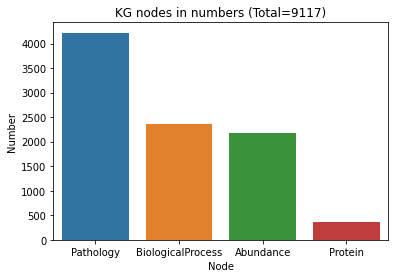

In [5]:
node_data = {'Node':['Pathology','BiologicalProcess','Abundance','Protein'],
       'Number':[4220, 2356, 2181, 360]}
node = pd.DataFrame(node_data)
a = sns.barplot(x="Node", y="Number", data=node)
a.set(xlabel='Node',ylabel='Number',title= 'KG nodes in numbers (Total=9117)')

# Bar plots for namespace types

[Text(0.5, 0, 'Number'),
 Text(0, 0.5, 'Namespace'),
 Text(0.5, 1.0, 'KG Namespace in numbers')]

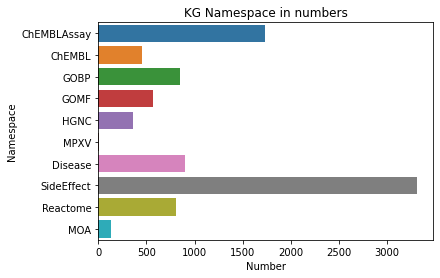

In [6]:
nspace_data = {'Namespace':['ChEMBLAssay','ChEMBL','GOBP','GOMF','HGNC','MPXV','Disease','SideEffect','Reactome','MOA'],
       'Number':[1732,449,846,568,360,10,905,3315,810,132]}
nspace = pd.DataFrame(nspace_data)

#a = sns.barplot(x="Number", y="Namespace", data=nspace_data)
#a.set(xlabel='Number',ylabel='Namespace',title= 'KG Namespace in numbers')

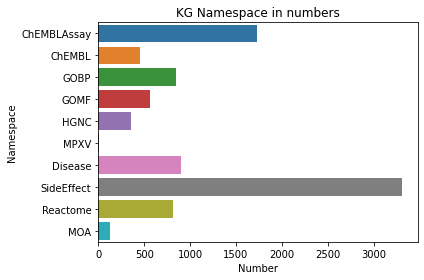

In [19]:
plt.figure()

a = sns.barplot(x="Number", y="Namespace", data=nspace_data)
a.set(xlabel='Number',ylabel='Namespace',title= 'KG Namespace in numbers')

plt.tight_layout()
plt.savefig('data/export/test2.png',dpi=600)
plt.show()

In [18]:

fig = a.get_figure()
plt.tight_layout()
plt.savefig('data/export/test.png',dpi=600)

<Figure size 432x288 with 0 Axes>

# Load file from Open Targets for info about 'druggability'

In [64]:
infile = open('data/opentargets//targets.pkl','rb')
targetability = pickle.load(infile)
infile.close()

In [65]:
#Fetch human proteins from KG
protein = []
for node in mpox_graph.nodes():
    if isinstance(node,pybel.dsl.Protein):
        if node.namespace == 'HGNC':
            protein.append(node.name)
            
len(protein)

350

In [66]:
targetability = targetability[targetability['approvedSymbol'].isin(protein)]
targetability = targetability.reset_index(drop=True)

In [67]:
#targetability[targetability['approvedSymbol']=='C1R']
targetability.dropna(subset=['tractability'],inplace=True)
targetability = targetability.reset_index(drop=True)
targetability.head(5)


,id,approvedSymbol,biotype,transcriptIds,genomicLocation,alternativeGenes,approvedName,go,hallmarks,synonyms,...,obsoleteNames,constraint,tep,proteinIds,dbXrefs,chemicalProbes,homologues,tractability,safetyLiabilities,pathways
0,ENSG00000105707,HPN,protein_coding,"[ENST00000600390, ENST00000541345, ENST0000026...","{'chromosome': '19', 'start': 35040506, 'end':...",None,hepsin,"[{'id': 'GO:0008233', 'source': 'PMID:19843851...",None,"[{'label': 'Serine protease hepsin', 'source':...",...,[],"[{'constraintType': 'syn', 'score': 0.69647997...",None,"[{'id': 'P05981', 'source': 'uniprot_swissprot...","[{'id': '5155', 'source': 'HGNC'}, {'id': '1O5...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,"[{'pathwayId': 'R-HSA-6806942', 'pathway': 'ME..."
1,ENSG00000115705,TPO,protein_coding,"[ENST00000650224, ENST00000382269, ENST0000032...","{'chromosome': '2', 'start': 1374066, 'end': 1...",None,thyroid peroxidase,"[{'id': 'GO:0098869', 'source': 'GO_REF:000010...",None,"[{'label': 'Thyroid peroxidase', 'source': 'un...",...,[],"[{'constraintType': 'syn', 'score': -0.8653900...",None,"[{'id': 'P07202', 'source': 'uniprot_swissprot...","[{'id': '12015', 'source': 'HGNC'}, {'id': 'CH...",None,"[{'speciesId': '9598', 'speciesName': 'Chimpan...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,"[{'pathwayId': 'R-HSA-209968', 'pathway': 'Thy..."
2,ENSG00000163254,CRYGC,protein_coding,[ENST00000282141],"{'chromosome': '2', 'start': 208128137, 'end':...",[ENSG00000285011],crystallin gamma C,"[{'id': 'GO:0002088', 'source': 'PMID:21873635...",None,"[{'label': 'Gamma-crystallin C', 'source': 'un...",...,"[{'label': 'crystallin, gamma C', 'source': 'H...","[{'constraintType': 'syn', 'score': -0.6277400...",None,"[{'id': 'P07315', 'source': 'uniprot_swissprot...","[{'id': '2410', 'source': 'HGNC'}, {'id': '2NB...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,None
3,ENSG00000138356,AOX1,protein_coding,"[ENST00000472553, ENST00000485965, ENST0000048...","{'chromosome': '2', 'start': 200586014, 'end':...",None,aldehyde oxidase 1,"[{'id': 'GO:0005506', 'source': 'PMID:26842593...",None,"[{'label': 'Aldehyde oxidase', 'source': 'unip...",...,[],"[{'constraintType': 'syn', 'score': -0.1202799...",None,"[{'id': 'Q06278', 'source': 'uniprot_swissprot...","[{'id': '553', 'source': 'HGNC'}, {'id': '4UHW...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...",None,"[{'pathwayId': 'R-HSA-964975', 'pathway': 'Vit..."
4,ENSG00000158748,HTR6,protein_coding,[ENST00000289753],"{'chromosome': '1', 'start': 19664875, 'end': ...",None,5-hydroxytryptamine receptor 6,"[{'id': 'GO:0030425', 'source': 'PMID:21873635...",None,"[{'label': '5-hydroxytryptamine receptor 6', '...",...,[{'label': '5-hydroxytryptamine (serotonin) re...,"[{'constraintType': 'syn', 'score': -0.9145399...",None,"[{'id': 'P50406', 'source': 'uniprot_swissprot...","[{'id': '5301', 'source': 'HGNC'}, {'id': 'CHE...",None,"[{'speciesId': '9606', 'speciesName': 'Human',...","[{'modality': 'SM', 'id': 'Approved Drug', 'va...","[{'event': 'receptor binding', 'eventId': None...","[{'pathwayId': 'R-HSA-418555', 'pathway': 'G a..."


# Create a file with 'druggability' label yes or no for human proteins

In [68]:
gene = []
flag = []
i = 0
#j = 0
for i in range(len(targetability)):

        
    #if pd.isna(targetability['tractability'][i].any() != True): 
    if targetability['tractability'][i][7]['value'] == True:

        gene.append(targetability['approvedSymbol'][i])
        flag.append('Yes')
        
    else:
        #print(targetability['approvedSymbol'][i])
        gene.append(targetability['approvedSymbol'][i])
        flag.append('No')

        

In [69]:
druggability = pd.DataFrame()
druggability['Gene'] = gene
druggability['Druggable Family'] = flag
druggability.to_csv('data/opentargets/druggability.csv',sep=',')

In [70]:
druggability

,Gene,Druggable Family
0,HPN,No
1,TPO,Yes
2,CRYGC,No
3,AOX1,Yes
4,HTR6,Yes
...,...,...
330,TNIK,Yes
331,CYP3A5,Yes
332,BBOX1,No
333,BRAF,Yes


# Create sub-graph for Supplementary File Outline no. 3

In [71]:
def filter_graph(mainGraph, vprotList):
    nsp_list = []
    chem_list = []
    for u, v, data in mainGraph.edges(data=True):
        if u.name in vprotList or v.name in vprotList:
            #print(u.name)
            nsp_list.append(u)
            #print(u)
            #print(v.name)
            nsp_list.append(v)

    nsp_graph = mainGraph.subgraph(nsp_list)
    #nsp_graph = pybel.struct.mutation.induction_expansion.get_subgraph_by_second_neighbors(mpox_graph, nsp_list, filter_pathologies=False)
    return(nsp_graph)


In [72]:
query = 'p28 TK B4R Q8V4Y0 MKRN3 MKRN4P MKRN1 MKRN2 RNF8 TK1 SLFN12 SLFN12L CA3 CA13 CA5A CA1 CA2'.split(' ')
#query = ['Virus Diseases','Smallpox']
#query = 'NS5B CYP3A4 IMPDH1'.split(' ')

In [73]:
query_graph = filter_graph(mpox_graph,query)

In [74]:
to_jupyter(query_graph)

<IPython.core.display.Javascript object>

# Export final KG to other standard formats

In [75]:
#to cytoscape compatible graphml 
pybel.to_graphml(mpox_graph,'data/export//Monkeypox_KG_jan15.graphml')

#to regular BEL format
pybel.dump(mpox_graph,'data/export//Monkeypox_KG_jan15.bel')

#to neo4j
pybel.to_csv(mpox_graph,'data/export//Monkeypox_KG_jan15.csv')

#to sif
pybel.to_sif(mpox_graph,'data/export//Monkeypox_KG_jan15.sif')

#to xml

#pybel.to

# Exporting graph to Neo4J

In [8]:
## to Neo4j
# Exporting graph to Neo4J
import py2neo
node_map = {}

# NEO4J_USER = 'yojana'
# NEO4J_PASS = 'abc'

#neo_connection = py2neo.Graph('bolt://localhost:7687', auth=('neo4j', 'itmp'),name='mpoxkg')
neo_connection = py2neo.Graph('neo4j+s://7feb81c0.databases.neo4j.io', auth=('fraunhofer', 'monkeypox-2022'))
#neo_connection.delete_all()
tx = neo_connection.begin()

nodes = list(mpox_graph)

dbio = nx.get_node_attributes(mpox_graph,'3Dbio')
uprot = nx.get_node_attributes(mpox_graph,'UniProt')
chembl = nx.get_node_attributes(mpox_graph,'ChEMBL')

for node in tqdm(nodes, desc="nodes"):
    attrs = {"namespace": node.namespace}

    if node.name and node.identifier:
        attrs["name"] = node.name
        attrs["identifier"] = node.identifier
    elif node.identifier and not node.name:
        attrs["name"] = node.identifier
    elif node.name and not node.identifier:
        attrs["name"] = node.name
    
    if node in dbio:
        attrs['3Dbio'] = dbio[node]
        
    if node in uprot:
        attrs['UniProt'] = uprot[node]
        
    if node in chembl:
        attrs['ChEMBL'] = chembl[node]

    node_map[node] = py2neo.Node(node.function, **attrs)

    tx.create(node_map[node])

edges = mpox_graph.edges(keys=True, data=True)

for u, v, key, node in tqdm(edges, desc="edges"):
    rel_type = node['relation']

    d = node.copy()
    del d['relation']

    attrs = {}

    annotations = d.pop('annotations', None)
    if annotations:
        for annotation, values in annotations.items():
            attrs[annotation] = list(values)

    citation = d.pop('citation', None)
    if citation:
        attrs['citation'] = citation.curie

    if 'evidence' in d:
        attrs['evidence'] = d['evidence']

    rel = py2neo.Relationship(node_map[u], rel_type, node_map[v], key=key, **attrs)
    tx.create(rel)
    
tx.commit()

edges: 100%|██████████| 44317/44317 [1:43:38<00:00,  7.13it/s]  
C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_22896\3169164925.py:69: DeprecationWarning: The transaction.commit() method is deprecated, use graph.commit(transaction) instead
  tx.commit()


In [9]:
###new

In [ ]:
#Fetch human/viral proteins from KG
#use HGNC or MPXV
protein = []
for node in mpox_graph.nodes():
    if isinstance(node,pybel.dsl.Protein):
        if node.namespace == 'MPXV':
            protein.append(node.name)
            
len(protein)

In [ ]:
protein

# Implementation for Results section in manuscript

# Get list of drugs that are used to treat "Virus Diseases"

In [76]:
query = ['Virus Diseases','Smallpox']

In [77]:
viral_drugs_kg = filter_graph(mpox_graph,query)
to_jupyter(viral_drugs_kg)

<IPython.core.display.Javascript object>

In [78]:
def getChemfromKG(mainGraph):

    chem_list = []
    for u, v, data in mainGraph.edges(data=True):
        
        if 'CHEMBL' in u.name:
            if u.name not in chem_list:
                chem_list.append(u.name)

        if 'CHEMBL' in v.name:
            if v.name not in chem_list:
                chem_list.append(v.name)
                
    return(chem_list)



In [79]:
viral_drugs = getChemfromKG(viral_drugs_kg)
viral_drugs

['CHEMBL584',
 'CHEMBL318153',
 'CHEMBL115',
 'CHEMBL1257073',
 'CHEMBL152',
 'CHEMBL1643',
 'CHEMBL1259059',
 'CHEMBL3137312',
 'CHEMBL61',
 'CHEMBL57',
 'CHEMBL50300',
 'CHEMBL116',
 'CHEMBL853',
 'CHEMBL1490434',
 'CHEMBL163']

# Function to retrieve chemicals in Phase IV, Modification to RetDrugInd function

In [80]:
def RetDrugInd_phase4(chemblIDs) -> dict:
    """Function to retrieve associated diseases from ChEMBL

    :param chemblIDs:
    :return:
    """
    getDrugInd = new_client.drug_indication

    drugIndList = []
    for chemblid in tqdm(chemblIDs, desc='Retrieving diseases from ChEMBL'):
        drugInd = getDrugInd.filter(
            molecule_chembl_id=chemblid
        ).only(['mesh_heading','max_phase_for_ind'])
        
        data = []
        
#         print(drugInd)
#         break
        
        for ind in drugInd:
            if int(ind.get('max_phase_for_ind')<4):
                continue
            data.append(ind)
                
        
        drugIndList.append(list(data))

    named_drugIndList = dict(zip(chemblIDs, drugIndList))
    named_drugIndList = {
        k: v
        for k, v in named_drugIndList.items()
        if v
    }
    return named_drugIndList

In [81]:
phase4_drugs = RetDrugInd_phase4(viral_drugs)
phase4_drugs


Retrieving diseases from ChEMBL: 100%|██████████| 15/15 [00:00<00:00, 289.15it/s]


{'CHEMBL584': [{'max_phase_for_ind': 4, 'mesh_heading': 'Virus Diseases'}],
 'CHEMBL115': [{'max_phase_for_ind': 4, 'mesh_heading': 'Virus Diseases'}],
 'CHEMBL1257073': [{'max_phase_for_ind': 4, 'mesh_heading': 'Virus Diseases'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Smallpox'}],
 'CHEMBL152': [{'max_phase_for_ind': 4, 'mesh_heading': 'Virus Diseases'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Cytomegalovirus Retinitis'},
  {'max_phase_for_ind': 4,
   'mesh_heading': 'Primary Immunodeficiency Diseases'}],
 'CHEMBL1643': [{'max_phase_for_ind': 4,
   'mesh_heading': 'Hepatitis C, Chronic'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Liver Cirrhosis'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Virus Diseases'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Fibrosis'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Fibrosis'}],
 'CHEMBL1259059': [{'max_phase_for_ind': 4, 'mesh_heading': 'Hepatitis C'},
  {'max_phase_for_ind': 4, 'mesh_heading': 'Hepatitis C, Chronic'},
  {'max_phas

In [82]:
#convert dict to a dataframe

#step 1
#generate list for chemicals that have sub-dict
chem_list = []
for chem in phase4_drugs:
    for dis in phase4_drugs[chem]:
        chem_list.append(chem)

#step 2
#create df from sub-dict        
phase4drugs = pd.concat([pd.DataFrame(d) for d in phase4_drugs.values()], ignore_index=True)

#step 3
#append step 1 to step 2
phase4drugs['Drug'] = chem_list

In [83]:
phase4drugs.head(5)
phase4drugs.to_csv('data/export/phase4drugs.csv')


In [84]:
drugs_CT4 = list(phase4_drugs.keys())
drugs_CT4

['CHEMBL584',
 'CHEMBL115',
 'CHEMBL1257073',
 'CHEMBL152',
 'CHEMBL1643',
 'CHEMBL1259059',
 'CHEMBL3137312',
 'CHEMBL61',
 'CHEMBL57',
 'CHEMBL116',
 'CHEMBL853',
 'CHEMBL163']

# Extend chemical nodes with Mech. of action and target proteins, filter out diseases, sideEffect and assays

In [85]:
query_graph = filter_graph(mpox_graph,drugs_CT4)
filter_se = []
for node in query_graph:
    if node.namespace == 'SideEffect' or node.namespace == 'Disease' or node.namespace== 'ChEMBLAssay':
        filter_se.append(node)




In [86]:
G = query_graph.copy()
G.remove_nodes_from([n for n in G if n in set(filter_se)])

In [87]:
to_jupyter(G)

<IPython.core.display.Javascript object>

In [ ]:
mpox_chembl

In [ ]:
viral_drugs

In [ ]:
list(set(mpox_chembl)&set(viral_drugs))

# Misc

In [ ]:
def RetMech(chemblIds) -> dict:
    """Function to retrieve mechanism of actions and target proteins from ChEMBL

    :param chemblIds:
    :return:
    """
    getMech = new_client.mechanism

    mechList = []
    for chemblid in tqdm(chemblIds, desc='Retrieving mechanisms from ChEMBL'):
        mechs = getMech.filter(
            molecule_chembl_id=chemblid
        ).only(['mechanism_of_action', 'mechanism_refs','target_chembl_id','action_type'])
        
        
        mechList.append(list(mechs))
        


    named_mechList = dict(zip(chemblIds, mechList))
    named_mechList = {
        k: v
        for k, v in named_mechList.items()
        if v
    }
    return named_mechList


In [ ]:
a ='CHEMBL1643'
test = RetMech(viral_drugs)
test


In [ ]:
to_jupyter(filter_graph(mpox_graph,'NS5B'))

In [ ]:
#test
import networkx as nx

tg = pybel.BELGraph(name='Monkeypox Graph', version="0.0.1")

tg = uniprot_rel(protList_ext, 'HGNC', tg)
